In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import xarray as xr
from tqdm import tqdm
from itertools import product
from scipy.constants import c
import scipy.constants as const

## Interleaver source code

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import sys

from lmphoton import OptElement, OptColumn, OptRow, OptNetwork
from lmphoton.transforms import reflect
from lmphoton.models import Laser, Detector, BeamSplitter, DirectionalCoupler, Absorber, Waveguide, LossElement
from lmphoton.simulation import current_simulation as sim

from scipy.optimize import minimize
from scipy.signal import find_peaks
from functools import partial

import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

In [3]:
um = 1e-6

center_wavelength = 1310e-9
freq = c/(center_wavelength)
FSR_wavelength = 3200e9 * (center_wavelength)**2/(c)
channel_spacing = FSR_wavelength/8
channel1_wavelength = center_wavelength - 3.5*channel_spacing
channel2_wavelength = center_wavelength - 2.5*channel_spacing
channel3_wavelength = center_wavelength - 1.5*channel_spacing
channel4_wavelength = center_wavelength - 0.5*channel_spacing
channel5_wavelength = center_wavelength + 0.5*channel_spacing
channel6_wavelength = center_wavelength + 1.5*channel_spacing
channel7_wavelength = center_wavelength + 2.5*channel_spacing
channel8_wavelength = center_wavelength + 3.5*channel_spacing
channel_wavelength_array = [
    channel1_wavelength,
    channel2_wavelength,
    channel3_wavelength,
    channel4_wavelength,
    channel5_wavelength,
    channel6_wavelength,
    channel7_wavelength,
    channel8_wavelength,
]

optimization_wavelength_sweep = np.linspace(1300e-9, 1320e-9,num=1001)

cost_function_plot_alpha = 0.3
bounds_epsilon = 5e-3

In [4]:
def calculate_spectrum_bandwidth(wav, port_amp, peak_distance = 400, total_channels = 8, IL_channel_offset = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9], bandwidth=1, center_wavelength = 1310e-9, c=3e8):
    channel_bandwidth_1dB = []
    channel_min_IL_bandwidth = []
    channel_center_freq = []
    channel_fsr = []
    min_IL_dB = []
    average_IL_dB = []
    ripple_IL_dB = []
    IL_dB = []
    
    port_amp_dB = 10*np.log10(port_amp)
    peaks, _ = find_peaks(port_amp, height=0.5, distance = 200)
    center_index = np.argmin(np.abs(wav[peaks]-center_wavelength))
    
    
    fsr = np.diff(peaks)
    
    for i in range(-4, 4):
        center_index_min = np.argwhere(wav == wav[peaks][center_index+i]).flatten()[0] - int(fsr[center_index-1+i]/2)
        center_index_max = np.argwhere(wav == wav[peaks][center_index+i]).flatten()[0] + int(fsr[center_index+i]/2)
    
        port_amp_dB_local_normalized = port_amp_dB[center_index_min:center_index_max] - np.max(port_amp_dB[center_index_min:center_index_max])
        wav_local = wav[center_index_min:center_index_max]
        
        peak_local, _ = find_peaks(port_amp_dB_local_normalized)
        
        if len(peak_local) > 2:
            if peak_local[0] < 50:
                peak_local = peak_local[1:3]
            else:
                peak_local = peak_local[0:2]
        elif len(peak_local) == 1:
            peak_local = [peak_local[0], peak_local[0]]
        elif len(peak_local) == 2:
            if peak_local[0] < 50:
                peak_local = [peak_local[1], peak_local[1]]
            
        higher_freq_index = peak_local[1]+ np.argmin(np.abs(port_amp_dB_local_normalized[peak_local[1]:-1] + bandwidth))
        lower_freq_index = np.argmin(np.abs(port_amp_dB_local_normalized[0:peak_local[0]] + bandwidth))
        
        higher_freq = c/wav_local[higher_freq_index]
        lower_freq = c/wav_local[lower_freq_index]

        peaks_2,_ = find_peaks(port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index])

        if len(peaks_2) > 1:
            craters_2,_ = find_peaks(-port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index])

        if len(peaks_2) > 1:
            craters_2,_ = find_peaks(-port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index])
            average_IL_dB.append(np.average(port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index][peaks_2[0]:peaks_2[1]]))
            min_IL_dB.append(np.average(port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index][peaks_2]))
            ripple_IL_dB.append(np.average(port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index][craters_2]))
            channel_min_IL_bandwidth.append(((c/wav_local[lower_freq_index:higher_freq_index][peaks_2[0]] - c/wav_local[lower_freq_index:higher_freq_index][peaks_2[1]])))
        elif len(peaks_2) == 1:
            average_IL_dB.append(port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index][peaks_2][0])            
            min_IL_dB.append(port_amp_dB[center_index_min:center_index_max][lower_freq_index:higher_freq_index][peaks_2][0])
            ripple_IL_dB.append(0)
            channel_min_IL_bandwidth.append(0)
        
        
        channel_center_freq.append(lower_freq/2 + higher_freq/2)
        channel_bandwidth_1dB.append(((lower_freq - higher_freq)))
        
        ## calculating the RF signal spectrum        
        if i == 0:
            for offset in IL_channel_offset:
                diff_freq = c/wav_local - (lower_freq/2 + higher_freq/2) + offset
                Tb = 1/(56e9)
                rf_data_before_interleaver = np.array(
                    [0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])
                rf_data_before_interleaver /= np.max(rf_data_before_interleaver)

                rf_data_after_interleaver = rf_data_before_interleaver * port_amp[center_index_min:center_index_max]

                IL_linear = np.sum(rf_data_after_interleaver) / np.sum(rf_data_before_interleaver)
                IL_dB.append(10*np.log10(IL_linear))
    channel_fsr = np.diff(channel_center_freq)
    
    spectrum_fom = {
        "1dB_bandwidth": np.array(channel_bandwidth_1dB[0:total_channels]),
        "channel_center_frequency": np.array(channel_center_freq[0:total_channels]),         
        "min_dc_il_bandwidth": np.array(channel_min_IL_bandwidth[0:total_channels]),
        "rf_il_dB": np.array(IL_dB[0:total_channels]), 
        "min_dc_il_dB": np.array(min_IL_dB[0:total_channels]), 
        "ave_dc_il_dB": np.array(average_IL_dB[0:total_channels]), 
        "ripple_dc_il_dB": np.array(ripple_IL_dB[0:total_channels]), 
    }
    
    return spectrum_fom

In [5]:
from typing import Callable, Tuple, Union
import numpy as np

from lmphoton import OptElement
from lmphoton.constants import dndT_Si
from lmphoton.helpers import db2mag

from lmphoton.simulation import current_simulation as sim

um = 1e-6


class HPS_PhaseShifter(OptElement):
    """
    Model of HPS Phase Shifter.
    Args:
        ports (optional): S-matrix ports mapping.
        name (optional): String name of the element.
        voltage (optional): Voltage (V).
    """

    def __init__(
        self,
        ports: Tuple[str, str] = ("1l", "2r"),
        name: str = "HPS",
        length: float = 300 * um,
        index: Union[float, Callable] = 2.4,
        group_index: Union[float, Callable] = 4.385,
        loss: Union[float, Callable] = 0.08336,
    ):
        # Physical constants
        self._length = length
        self._index = index
        self.ng = group_index
        self.dn_dlambda = (self._index - self.ng) / (1.31e-6)
        self._loss = self._genvar(loss)
        self._time_ref = sim().time
        self.rc_filter_bool = False

        # Thermal properties
        self._heater_voltage = 0.0
        self.thermal_time_constant1 = 6.15e-6
        self.thermal_time_constant2 = 56e-6
        self.thermal_weight1 = 0.67
        self.thermal_weight2 = 0.33
        self.heater_coeff_A = -2.19042885e-5
        self.heater_coeff_B = -2.12241092e-5
        self.heater_coeff_C = 1.12634676e-3
        self.thermal_resistance = 5012  # Degrees C per Watt
        self._waveguide_temperature = 0
        super().__init__(ports=ports, name=name)

    @property
    def length(self):
        """Waveguide length (m)."""
        return self._length

    @property
    def heater_voltage(self):
        return self._heater_voltage

    @heater_voltage.setter
    def heater_voltage(self, new_voltage):
        self._heater_voltage = new_voltage
        self._time_ref = sim().time
        self.update()

    @property
    def heater_power(self):
        heater_current = (
            self.heater_coeff_A * np.power(self._heater_voltage, 3)
            + self.heater_coeff_B * np.power(self._heater_voltage, 2)
            + self.heater_coeff_C * self._heater_voltage
        )
        return heater_current * self._heater_voltage

    @property
    def waveguide_temperature(self):
        new_temp = self.thermal_resistance * self.heater_power + self._temp
        if self.rc_filter_bool is True:
            t0 = self._time_ref
            t1 = sim().time
            self._waveguide_temperature = self._waveguide_temperature + (
                new_temp - self._waveguide_temperature
            ) * (
                1
                - self.thermal_weight1
                * np.exp(-(t1 - t0) / self.thermal_time_constant1)
                - self.thermal_weight2
                * np.exp(-(t1 - t0) / self.thermal_time_constant2)
            )
            self._time_ref = sim().time
        elif self.rc_filter_bool is False:
            self._waveguide_temperature = new_temp
        return self._waveguide_temperature

    @property
    def index(self):
        """Guided mode index."""
        return (
            self._index
            + dndT_Si * (self.waveguide_temperature - 300.0)
            + (self._wavelength - 1.31e-6) * self.dn_dlambda
        )

    @property
    def wavenumber(self):
        """Guided mode wavenumber."""
        beta = self.index * 2 * np.pi / self._wavelength
        return beta

    @property
    def complex_phase(self):
        return self.wavenumber * self.length

    def _construct_smatrix(self):
        s21 = np.exp(-1j * self.complex_phase) * db2mag(-self._loss)
        return [[0.0, s21], [s21, 0.0]]

    def check_children_timesteps(self):
        if abs(self._time_ref - sim().time) < sim().time_step:
            return True
        else:
            print(
                f"Component {self.name} has time reference {self._time_ref} but simulation time is different at {sim().time}"
            )


In [6]:
class interleaver_2_stage_calc(OptRow):
    def __init__(self,
                L = 1*um,
                dL1 = 484.135*um,         
                dL2 = 50.8*um,
                dL3 = 968.27*um, 
                dL4 = 101.6*um,
                dc1 = 0.5,
                dc2 = 0.5,
                dc3 = 0.5,
                effective_index = 1.58,
                group_index = 1.94,
                FSR_wavelength = 8*um,
                SiN_propagation_loss_dB_m = 40,
                XPS_first_stage_loss_dB = 0.07,
                SiN_directional_coupler_loss_dB = 0.02,
                ports = ['1l PORT1', '2r PORT2', '3r PORT3', '4l PORT4'],
                name = 'INTERLEAVER_2STAGE'):

        self.FSR_wavelength = 1600e9 * 1310e-9**2/const.c

        self.sin_effective_index = 1.587
        self.sin_group_index = 1.94
        
        self.si_effective_index = 2.4
        self.si_group_index = 4.34
        
        self.sin_propagation_loss_dB_m = 30
        self.HPS_insertion_loss_dB = 0.01
        self.sin_coupler_loss_dB = 0.12
        
        self.L = L
        self.channel_spacing = self.FSR_wavelength / 8.0

        self.wg0 = Waveguide(length=L+dL1,index=self.sin_effective_index,group_index=self.sin_group_index, loss_rate = 0.01*self.sin_propagation_loss_dB_m)
        self.wg1 = Waveguide(length=L,    index=self.sin_effective_index,group_index=self.sin_group_index, loss_rate = 0.01*self.sin_propagation_loss_dB_m)
        self.wg2 = Waveguide(length=dL2,index=self.si_effective_index,group_index=self.si_group_index, loss_rate = 0.01*self.sin_propagation_loss_dB_m)

        self.HPS0 = HPS_PhaseShifter()
        self.HPS1 = HPS_PhaseShifter()

        self.wg3 = Waveguide(length=L+dL3, index=self.sin_effective_index, group_index=self.sin_group_index, loss_rate = 0.01*self.sin_propagation_loss_dB_m)
        self.wg4 = Waveguide(length=L,     index=self.sin_effective_index, group_index=self.sin_group_index, loss_rate = 0.01*self.sin_propagation_loss_dB_m)
        self.wg5 = Waveguide(length=dL4,   index=self.si_effective_index, group_index=self.si_group_index, loss_rate = 0.01*self.sin_propagation_loss_dB_m)

        self.HPS2 = HPS_PhaseShifter()
        self.HPS3 = HPS_PhaseShifter()

        self.dc0 = DirectionalCoupler(splitratio=dc1, loss = self.sin_coupler_loss_dB)
        self.dc1 = DirectionalCoupler(splitratio=dc2, loss = self.sin_coupler_loss_dB)
        self.dc2 = DirectionalCoupler(splitratio=dc3, loss = self.sin_coupler_loss_dB)

        ########## Time domain parameters ###############
        self.HPS0.heater_voltage = 0.0
        self.HPS1.heater_voltage = 0.0
        self.HPS2.heater_voltage = 0.0
        self.HPS3.heater_voltage = 0.0

        ########## Enable aggressors ###############
        self._enable_aggressors = False

        self._rc_filter_bool = False
        self._time_ref = sim().time

        # Construct network:
        network = [
            self.dc0,
            OptColumn(
                [
                    self.wg0,
                    OptRow([
                        self.wg1,
                        self.wg2])
                ]
            ),
            OptColumn(
                [
                    self.HPS0,
                    self.HPS1,
                ]
            ),
            self.dc1,
            OptColumn(
                [
                    self.wg3,
                    OptRow([
                        self.wg4,
                        self.wg5
                    ])
                ]
            ),
            OptColumn(
                [
                    self.HPS2,
                    self.HPS3,
                ]
            ),
            self.dc2
        ]
        
        super().__init__(
            network,
            # ports=ports, 
            name=name
        )

    @property
    def phase_shift_1_top(self):
        return self.wg0._init_phase

    @phase_shift_1_top.setter
    def phase_shift_1_top(self, x):
        self.wg0._init_phase = x

    @property
    def phase_shift_2_top(self):
        return self.wg3._init_phase

    @phase_shift_2_top.setter
    def phase_shift_2_top(self, x):
        self.wg3._init_phase = x

    @property
    def phase_shift_1_bot(self):
        return self.wg1._init_phase

    @phase_shift_1_bot.setter
    def phase_shift_1_bot(self, x):
        self.wg1._init_phase = x

    @property
    def phase_shift_2_bot(self):
        return self.wg4._init_phase

    @phase_shift_2_bot.setter
    def phase_shift_2_bot(self, x):
        self.wg4._init_phase = x

    def top_input_bar_port_transmission(self):
        return np.real(self.smatrix[2,0] * np.conj(self.smatrix[2,0]))
    
    def bottom_input_bar_port_transmission(self):
        return np.real(self.smatrix[3,1] * np.conj(self.smatrix[3,1]))

    def top_input_cross_port_transmission(self):
        return np.real(self.smatrix[3,0] * np.conj(self.smatrix[3,0]))
    
    def bottom_input_cross_port_transmission(self):
        return np.real(self.smatrix[2,1] * np.conj(self.smatrix[2,1]))
    
    # Create optimal transfer function (square wave in frequency space)
    def calculate_optimal_transfer_function(self):
        optimal_transfer_function = np.array(
            [
                int(1*(i- 1310e-9 - self.channel_spacing/2)/self.channel_spacing % 2) for i in optimization_wavelength_sweep
            ]
        )
        return optimal_transfer_function
    
    def calculate_cost_function(self, param_list, info, printy=False):
        dc1, dc2, dc3, phi1, phi2 = param_list
        _, bar_port_response, cross_port_response = self.calculate_spectrum(dc1,dc2,dc3, phi1,phi2)
        cost = np.sum(np.abs(self.calculate_optimal_transfer_function() - bar_port_response)) 
        cost += np.sum(np.abs(1 - self.calculate_optimal_transfer_function() - cross_port_response)) # 1 - is to flip the response for the cross port. #I'm summing both the bar and cross response to give equally weighting to pass and stop bands

        # display information
        if (info['Nfeval'] == 0) and (printy == True):
            print("  #      DC1        DC2        DC3       phi1      phi2       Cost")
        if (info['Nfeval']%10 == 0) and (printy == True):
            print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f} {6: 3.6f}'.format(
                info['Nfeval'],
                dc1,
                dc2,
                dc3,
                phi1,
                phi2,
                cost
            )
        )
        info['Nfeval'] += 1
        return cost
        
    def minimize_cost_function(
            self,
            random_dc = True,
            random_phase=True,
            printy = False
    ):
        initial_condition = []
        bounds = []

        if random_dc == True:
            for _ in range(3):
                initial_condition.append(np.random.rand())
                bounds.append((0,1))
        elif random_dc == False:
            initial_condition.append(self.dc0._splitratio)
            initial_condition.append(self.dc1._splitratio)
            initial_condition.append(self.dc2._splitratio)

            bounds.append(
                (self.dc0._splitratio - bounds_epsilon, self.dc0._splitratio + bounds_epsilon)
                )
            bounds.append(
                (self.dc1._splitratio - bounds_epsilon, self.dc1._splitratio + bounds_epsilon)
                )
            bounds.append(
                (self.dc2._splitratio - bounds_epsilon,self.dc2._splitratio + bounds_epsilon)
                )
        if random_phase == True:
            for _ in range(2):
                initial_condition.append(np.pi*(2*np.random.rand()-1))
                bounds.append((-2*np.pi, 2*np.pi))
        elif random_phase == False:
            initial_condition.append(self.phase_shift_1_top)
            initial_condition.append(self.phase_shift_2_top)
            bounds.append(
                (self.phase_shift_1_top - bounds_epsilon, self.phase_shift_1_top + bounds_epsilon)
                )
            bounds.append(
                (self.phase_shift_2_top - bounds_epsilon, self.phase_shift_2_top + bounds_epsilon)
                )
            
        result = minimize(
            partial(self.calculate_cost_function, printy=printy),
            initial_condition,
            method='Nelder-Mead',
            bounds=bounds,
            args=({'Nfeval': 0},),
            options={
                "maxiter": 1000,
                'xatol': 1e-3,
                'fatol': 1e-3,
            },
        )

        return result
    
    def calculate_spectrum(self, dc1, dc2, dc3, phi1_top, phi2_top, phi1_bot = 0, phi2_bot = 0):
        self.dc0._splitratio = dc1
        self.dc1._splitratio = dc2
        self.dc2._splitratio = dc3

        self.phase_shift_1_top = phi1_top
        self.phase_shift_2_top = phi2_top
        self.phase_shift_1_bot = phi1_bot
        self.phase_shift_2_bot = phi2_bot

        cross_storage = []
        bar_storage = []
        for wav in optimization_wavelength_sweep:
            sim().wavelength = wav
            self.recursive_update()
            cross_storage.append(self.top_input_cross_port_transmission())
            bar_storage.append(self.top_input_bar_port_transmission())

        cross_storage = np.array(cross_storage)
        bar_storage = np.array(bar_storage)

        return optimization_wavelength_sweep, bar_storage, cross_storage
                
    def RF_spectrum_56G(self):
        frequency_sweep = c/optimization_wavelength_sweep
        diff_freq = freq - frequency_sweep
        Tb = 1/(56e9)
        tp = np.array(
            [0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])
        tp /= np.max(tp)
        return tp

    def calculate_spectrum_IL_and_crosstalk_from_sweep(self, bar_storage, cross_storage):
        #First, we calculate the RF spectrum in the optical domain for 56G encoded data
        rf_spectrum_before_interleaver = self.RF_spectrum_56G()

        rf_data_after_interleaver = rf_spectrum_before_interleaver * bar_storage
        rf_data_crosstalk_after_interleaver = rf_spectrum_before_interleaver * cross_storage

        IL_linear = np.sum(rf_data_after_interleaver) / \
            np.sum(rf_spectrum_before_interleaver)
        CT_linear = np.sum(rf_data_crosstalk_after_interleaver) / \
            np.sum(rf_spectrum_before_interleaver)

        return IL_linear, CT_linear
            

    def plot_spectrum(self, result):
        wav, bar_port_amp, cross_port_amp = self.calculate_spectrum(*result.x)
        cost_sweep = self.calculate_optimal_transfer_function()

        plt.figure()
        plt.plot(wav*1e9, bar_port_amp)
        plt.plot(wav*1e9, cross_port_amp)
        plt.plot(wav*1e9, bar_port_amp + cross_port_amp)
        plt.plot(wav*1e9, cost_sweep, alpha=cost_function_plot_alpha)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Transmission")
        plt.title("2 Stage Filter after optimization")
        plt.legend(['Bar', 'Cross', 'Total', 'Cost function'])
        plt.show()

        plt.figure()
        plt.plot(wav*1e9, 10*np.log10(bar_port_amp))
        plt.plot(wav*1e9, 10*np.log10(cross_port_amp))
        plt.plot(wav*1e9, 10*np.log10(bar_port_amp + cross_port_amp))
        plt.plot(wav*1e9, 10*np.log10(cost_sweep+1e-6),
                 zorder=-100, alpha=cost_function_plot_alpha)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Transmission (dB)")
        plt.title("Filter after optimization")
        plt.legend(["Bar", "Cross", 'Total', 'Cost function'])
        plt.ylim(-31, 1)
        plt.show()

## Interleaver solver

In [7]:
gf45clo_pdk_sin_neff_ng_variability = xr.open_dataset("gf45clo_pdk_sin_neff_ng_variability.nc")
gf45clo_pdk_sin_neff_ng_variability

<xarray.Dataset>
Dimensions:                (num_samples: 500, wg_width_median_array: 3)
Coordinates:
  * num_samples            (num_samples) int32 0 1 2 3 4 ... 495 496 497 498 499
  * wg_width_median_array  (wg_width_median_array) float64 0.8 1.4 2.0
Data variables:
    wg_width               (wg_width_median_array, num_samples) float64 ...
    wg_height              (wg_width_median_array, num_samples) float64 ...
    wg_sidewall_angle      (wg_width_median_array, num_samples) float64 ...
    wg_width_median        (wg_width_median_array, num_samples) float64 ...
    neff_freq0             (wg_width_median_array, num_samples) float32 ...
    neff_dfreq             (wg_width_median_array, num_samples) float64 ...
    ng_freq0               (wg_width_median_array, num_samples) float32 ...
    ng_dfreq               (wg_width_median_array, num_samples) float64 ...
Attributes:
    description:  gf45clo_pdk_sin_neff_ng_variability

In [8]:
XPS_first_stage_loss_dB   = 0.07
XPS_second_stage_loss_dB  = 0.07
XPS_third_stage_loss_dB   = 0.07
SiN_propagation_loss_dB_m = 40
SiN_directional_coupler_loss_dB = 0.02

SiN_group_index = []
SiN_effective_index = []
for width in [gf45clo_pdk_sin_neff_ng_variability['wg_width_median_array'].values[0]]:
  SiN_group_index.append(np.median(gf45clo_pdk_sin_neff_ng_variability.sel(wg_width_median_array=width)['ng_freq0'].values))
  SiN_effective_index.append(np.median(gf45clo_pdk_sin_neff_ng_variability.sel(wg_width_median_array=width)['neff_freq0'].values))

dL_400Ghz_FSR = []

for idd_width, width in enumerate([gf45clo_pdk_sin_neff_ng_variability['wg_width_median_array'].values[0]]):
  dL_400Ghz_FSR.append((center_wavelength)**2/(SiN_group_index[idd_width] * FSR_wavelength/8))

Idd_width:  0  Width:  0.8 um
dL for 400Ghz FSR:  0.0003879301671050113
  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000    0.287336  3.037760  1227.550326
  10    0.499920    0.635000    0.895520    0.283290  3.228288  1198.928670
  20    0.495469    0.635000    0.895243    0.285681  3.788149  1171.486334
  30    0.495000    0.635000    0.895000    0.286935  3.767400  1171.215073
  40    0.495092    0.635000    0.895051    0.290378  3.835185  1171.238296
  50    0.495074    0.635000    0.895027    0.292360  3.818656  1171.165034
  60    0.495000    0.635000    0.895005    0.280853  3.800675  1171.037853
  70    0.495111    0.635000    0.895013    0.234972  3.734155  1170.251423
  80    0.495241    0.635000    0.895023    0.113697  3.569562  1164.623083
  90    0.495805    0.635000    0.895076   -0.332740  2.951130  1101.656085
 100    0.498991    0.635000    0.895361   -2.582671 -0.059812  577.588261
 110    0.499422    0.6350

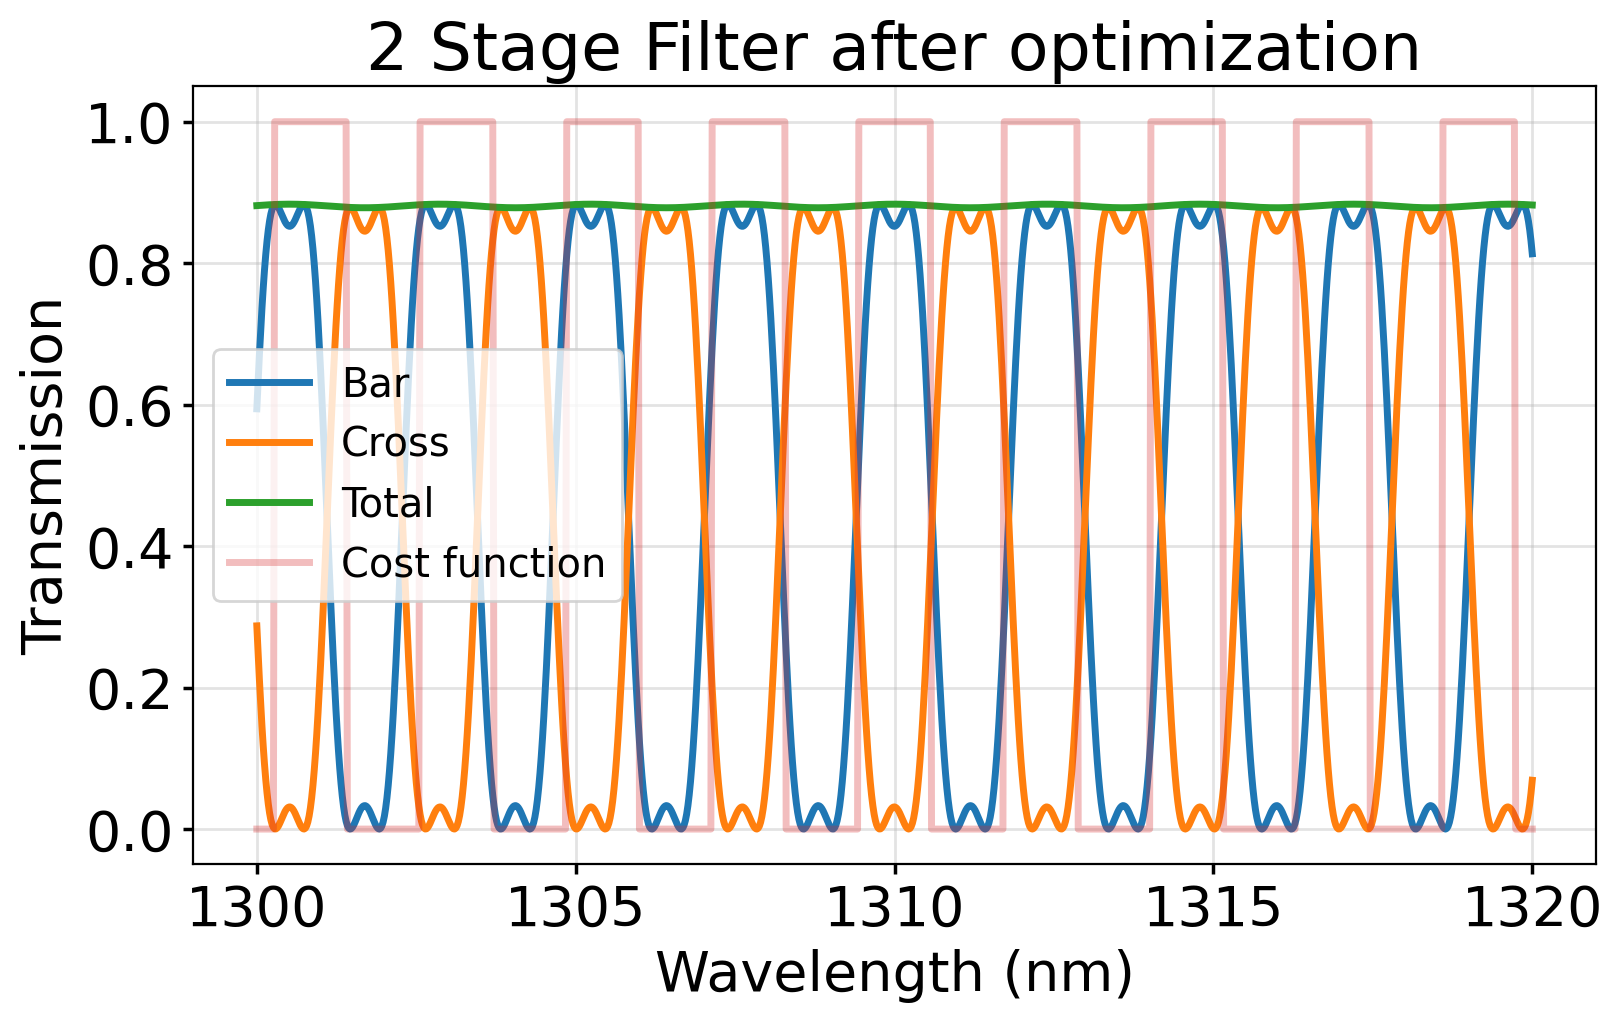

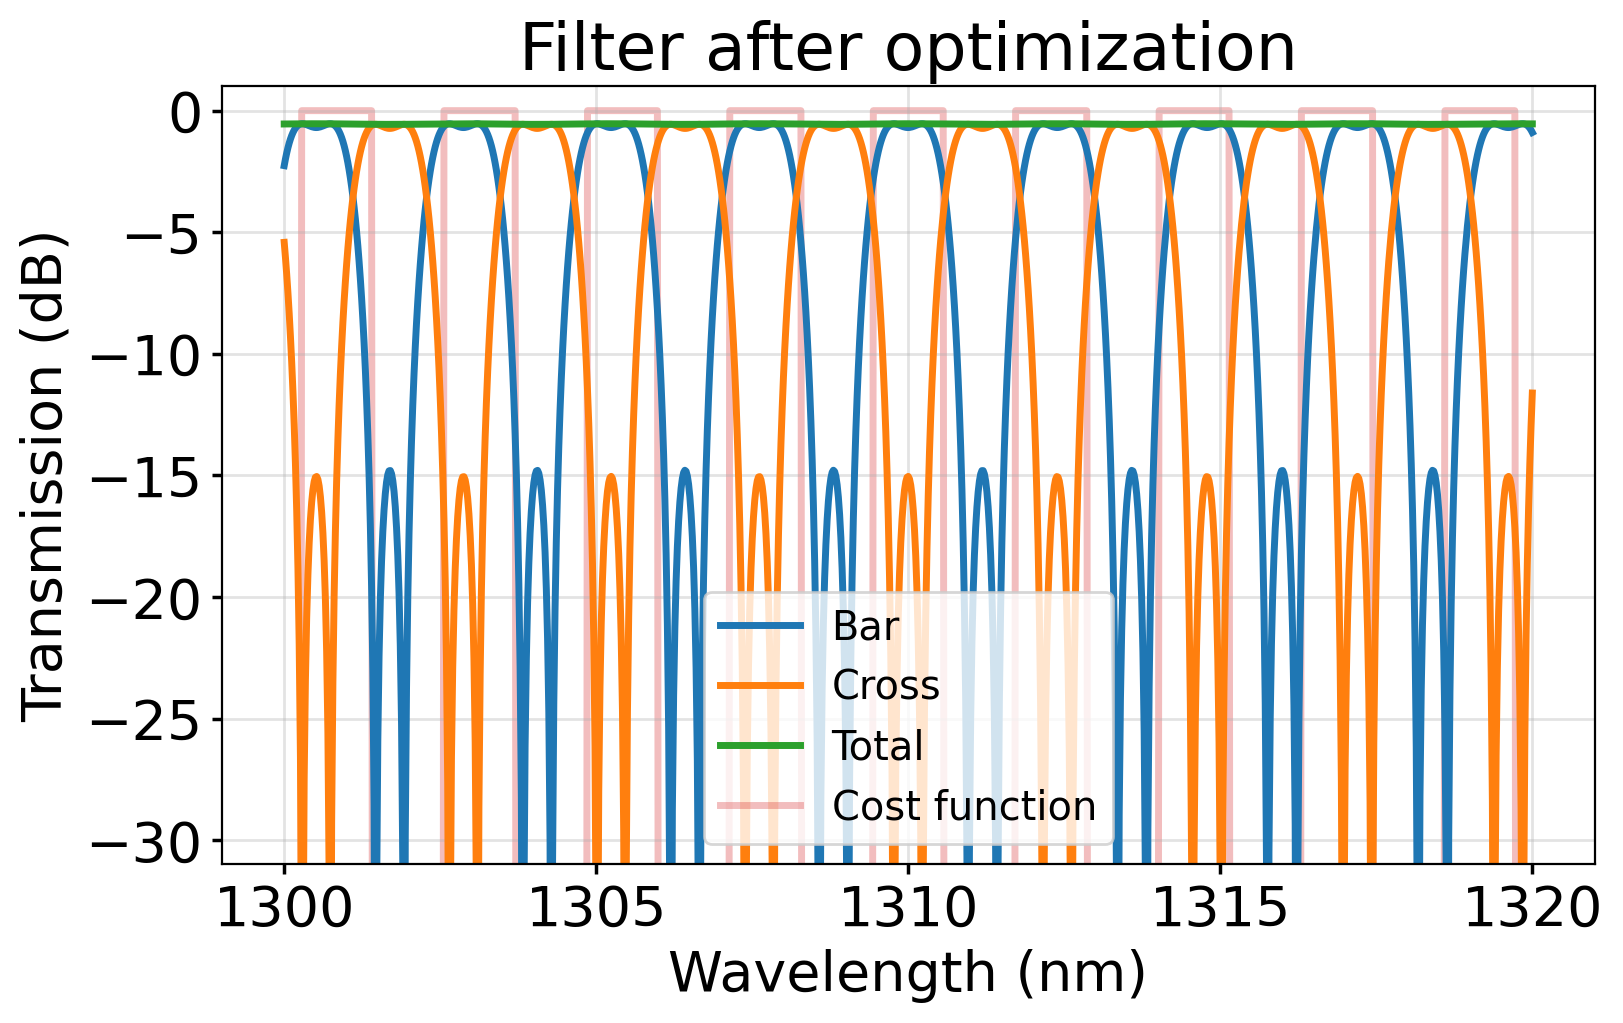

In [9]:
num_sweep = len(gf45clo_pdk_sin_neff_ng_variability['num_samples'].values)
num_sweep = 1

channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9]

random_variable_sigma = [0.02]#, 0.05, 0.1]

dc_variability = ["common"]
simulation = ["dc_variability"]

um = 1e-6

interleaver_dataset = {}

idd_interleaver = 1
um = 1e-6

print("Idd_width: ", idd_width," Width: ", width, "um")
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR[idd_width])
interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    # L = 350*um,
    # dL1 = dL_400Ghz_FSR[0],
    # dL2 = 2*dL_400Ghz_FSR[0],
    dc1 = 0.5,
    dc2 = 0.63,
    dc3 = 0.9,
    # effective_index = SiN_effective_index[0],
    # group_index = SiN_group_index[0],
    # FSR_wavelength = FSR_wavelength/2,
    # SiN_propagation_loss_dB_m = SiN_directional_coupler_loss_dB,
    # XPS_first_stage_loss_dB = XPS_first_stage_loss_dB,
    # SiN_directional_coupler_loss_dB = SiN_directional_coupler_loss_dB,
)

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

interleaver_400Ghz_FSR.plot_spectrum(interleaver_400Ghz_result)

In [10]:
interleaver_400Ghz_result.x

array([ 0.5027653 ,  0.635     ,  0.89543866, -2.75677499,  0.76805414])

In [11]:
interleaver_400Ghz_result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 492.55544273498646
             x: [ 5.028e-01  6.350e-01  8.954e-01 -2.757e+00  7.681e-01]
           nit: 148
          nfev: 247
 final_simplex: (array([[ 5.028e-01,  6.350e-01, ..., -2.757e+00,
                         7.681e-01],
                       [ 5.028e-01,  6.350e-01, ..., -2.757e+00,
                         7.679e-01],
                       ...,
                       [ 5.028e-01,  6.350e-01, ..., -2.757e+00,
                         7.678e-01],
                       [ 5.028e-01,  6.350e-01, ..., -2.757e+00,
                         7.685e-01]]), array([ 4.926e+02,  4.926e+02,  4.926e+02,  4.926e+02,
                        4.926e+02,  4.926e+02]))

In [12]:
interleaver_dict = {}
idd_interleaver = 1
bar_port_response_all = []
cross_port_response_all = []

num_samples = 101
num_samples = 21
phi1_range = np.linspace(-np.pi, np.pi, num=num_samples)
phi2_range = np.linspace(-np.pi, np.pi, num=num_samples)

for phi1, phi2 in tqdm(product(phi1_range,phi2_range), total=len(phi1_range)*len(phi2_range)):
  phi1_top, phi1_bot, phi2_top, phi2_bot = 0, 0, 0, 0
  if phi1 < 0:
    phi1_bot = -phi1
  else:
    phi1_top = phi1
  if phi2 < 0:
    phi2_bot = -phi2
  else:
    phi2_top = phi2

  wav, bar_port_response, cross_port_response = interleaver_400Ghz_FSR.calculate_spectrum(interleaver_400Ghz_result.x[0], interleaver_400Ghz_result.x[1], interleaver_400Ghz_result.x[2], phi1_top, phi2_top, phi1_bot, phi2_bot)
  bar_port_response_all.append(bar_port_response)
  cross_port_response_all.append(cross_port_response)

bar_port_response_all = np.array(bar_port_response_all).reshape(len(phi1_range),len(phi2_range),len(wav))
cross_port_response_all = np.array(cross_port_response_all).reshape(len(phi1_range),len(phi2_range),len(wav))

100%|██████████| 441/441 [02:07<00:00,  3.46it/s]


In [13]:
freq_offset_range = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9, 80e9, 90e9, 100e9, 120e9, 140e9, 160e9, 180e9, 200e9]
wav_offset_range = c/(c/center_wavelength + np.array(freq_offset_range)) - center_wavelength
wav_offset_range

array([ 0.00000000e+00, -5.72404331e-11, -1.14475864e-10, -1.71706294e-10,
       -2.28931723e-10, -2.86152152e-10, -3.43367582e-10, -4.00578013e-10,
       -4.57783445e-10, -5.14983881e-10, -5.72179319e-10, -6.86555209e-10,
       -8.00911119e-10, -9.15247055e-10, -1.02956302e-09, -1.14385903e-09])

In [14]:
channel_wavelength_array

[1.3019859891872263e-06,
 1.3042757065623044e-06,
 1.3065654239373827e-06,
 1.3088551413124608e-06,
 1.311144858687539e-06,
 1.3134345760626172e-06,
 1.3157242934376955e-06,
 1.3180140108127736e-06]

dfreq 0.0 [GHz], Cross Port Power 6.88 [mW], Bar Port Power 0.15 [mW]
dfreq 10.0 [GHz], Cross Port Power 6.86 [mW], Bar Port Power 0.17 [mW]
dfreq 20.0 [GHz], Cross Port Power 6.74 [mW], Bar Port Power 0.29 [mW]
dfreq 30.0 [GHz], Cross Port Power 6.57 [mW], Bar Port Power 0.46 [mW]
dfreq 40.0 [GHz], Cross Port Power 6.29 [mW], Bar Port Power 0.75 [mW]
dfreq 50.0 [GHz], Cross Port Power 5.92 [mW], Bar Port Power 1.11 [mW]
dfreq 60.0 [GHz], Cross Port Power 5.57 [mW], Bar Port Power 1.47 [mW]
dfreq 70.0 [GHz], Cross Port Power 5.08 [mW], Bar Port Power 1.96 [mW]
dfreq 80.0 [GHz], Cross Port Power 4.56 [mW], Bar Port Power 2.48 [mW]
dfreq 90.0 [GHz], Cross Port Power 4.04 [mW], Bar Port Power 3.01 [mW]
dfreq 100.0 [GHz], Cross Port Power 3.57 [mW], Bar Port Power 3.48 [mW]
dfreq 120.0 [GHz], Cross Port Power 2.55 [mW], Bar Port Power 4.50 [mW]
dfreq 140.0 [GHz], Cross Port Power 1.73 [mW], Bar Port Power 5.32 [mW]
dfreq 160.0 [GHz], Cross Port Power 1.07 [mW], Bar Port Power 5.99 [mW]
dfr

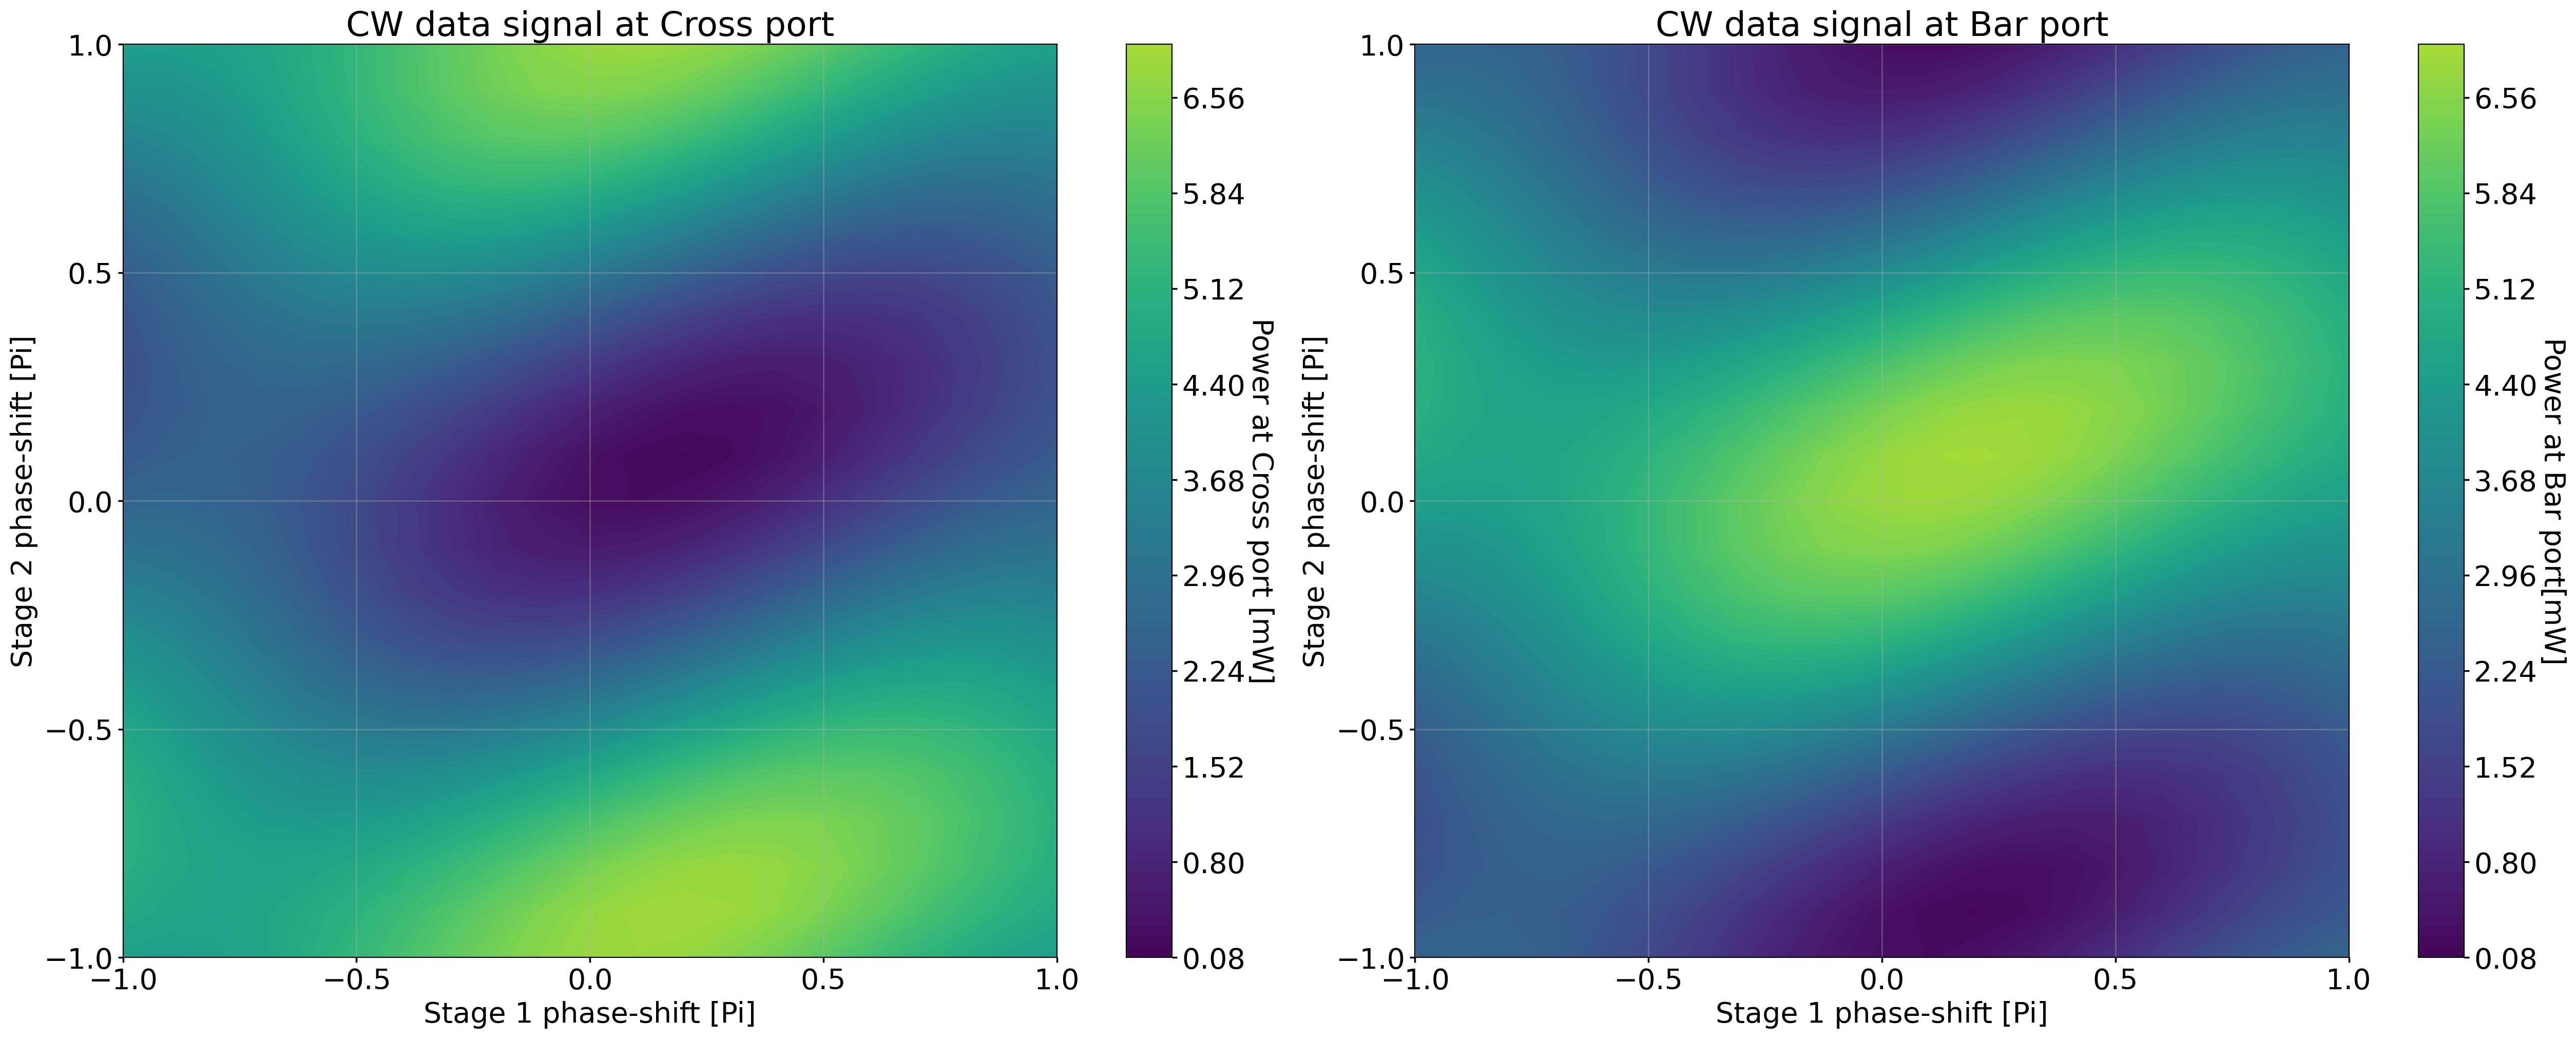

In [15]:

for idd_offset, wav_offset in enumerate(wav_offset_range):
  channel_wavelength_index = []
  for wav_focus in channel_wavelength_array:
    channel_wavelength_index.append(np.argmin(np.abs(wav-wav_focus + wav_offset)))

  bar_port_power_cw = np.zeros((num_samples,num_samples))
  cross_port_power_cw = np.zeros((num_samples,num_samples))

  for idd_phi1, idd_ph2 in product(range(num_samples),range(num_samples)):
    for idd_wavelength in channel_wavelength_index:
        bar_port_power_cw[idd_phi1,idd_ph2] += bar_port_response_all[idd_phi1,idd_ph2,idd_wavelength]
        cross_port_power_cw[idd_phi1,idd_ph2] += cross_port_response_all[idd_phi1,idd_ph2,idd_wavelength]
  
  if idd_offset == 0:
    for idd_phi1, idd_ph2 in product(range(num_samples),range(num_samples)):
      if cross_port_power_cw[idd_phi1,idd_ph2] == np.max(cross_port_power_cw):
        fix_idd_phi1 = idd_phi1
        fix_idd_phi2 = idd_ph2

  print(r"dfreq " + str(freq_offset_range[idd_offset]/1e9) + f" [GHz], Cross Port Power {cross_port_power_cw[fix_idd_phi1, fix_idd_phi2]:0.2f} [mW], Bar Port Power {bar_port_power_cw[fix_idd_phi1, fix_idd_phi2]:0.2f} [mW]")

  if idd_offset == 0:
    plt.figure(figsize=(25,10))
    plt.subplot(121)
    X, Y = np.meshgrid(phi1_range/np.pi, phi2_range/np.pi)
    plt.contourf(X, Y, cross_port_power_cw, levels = 101)
    cbar = plt.colorbar()
    cbar.set_label("Power at Cross port [mW]", rotation=270, labelpad=20)
    plt.clim(0,8)
    plt.xticks(np.linspace(-1,1,5))
    plt.yticks(np.linspace(-1,1,5))
    plt.xlabel("Stage 1 phase-shift [Pi]")
    plt.ylabel("Stage 2 phase-shift [Pi]")
    plt.title("CW data signal at Cross port")
    plt.subplot(122)
    X, Y = np.meshgrid(phi1_range/np.pi, phi2_range/np.pi)
    plt.contourf(X, Y, bar_port_power_cw, levels = 101)
    cbar = plt.colorbar()
    cbar.set_label("Power at Bar port[mW]", rotation=270, labelpad=20)
    plt.clim(0,8)
    plt.xticks(np.linspace(-1,1,5))
    plt.yticks(np.linspace(-1,1,5))
    plt.xlabel("Stage 1 phase-shift [Pi]")
    plt.ylabel("Stage 2 phase-shift [Pi]")
    plt.title("CW data signal at Bar port")

dfreq 0.0 [GHz], Cross Port Power 6.44 [mW], Bar Port Power 0.59 [mW]
dfreq 10.0 [GHz], Cross Port Power 6.41 [mW], Bar Port Power 0.62 [mW]
dfreq 20.0 [GHz], Cross Port Power 6.32 [mW], Bar Port Power 0.72 [mW]
dfreq 30.0 [GHz], Cross Port Power 6.15 [mW], Bar Port Power 0.88 [mW]
dfreq 40.0 [GHz], Cross Port Power 5.92 [mW], Bar Port Power 1.12 [mW]
dfreq 50.0 [GHz], Cross Port Power 5.62 [mW], Bar Port Power 1.41 [mW]
dfreq 60.0 [GHz], Cross Port Power 5.27 [mW], Bar Port Power 1.76 [mW]
dfreq 70.0 [GHz], Cross Port Power 4.88 [mW], Bar Port Power 2.16 [mW]
dfreq 80.0 [GHz], Cross Port Power 4.46 [mW], Bar Port Power 2.58 [mW]
dfreq 90.0 [GHz], Cross Port Power 4.02 [mW], Bar Port Power 3.02 [mW]
dfreq 100.0 [GHz], Cross Port Power 3.58 [mW], Bar Port Power 3.47 [mW]
dfreq 120.0 [GHz], Cross Port Power 2.73 [mW], Bar Port Power 4.32 [mW]
dfreq 140.0 [GHz], Cross Port Power 1.97 [mW], Bar Port Power 5.08 [mW]
dfreq 160.0 [GHz], Cross Port Power 1.35 [mW], Bar Port Power 5.71 [mW]
dfr

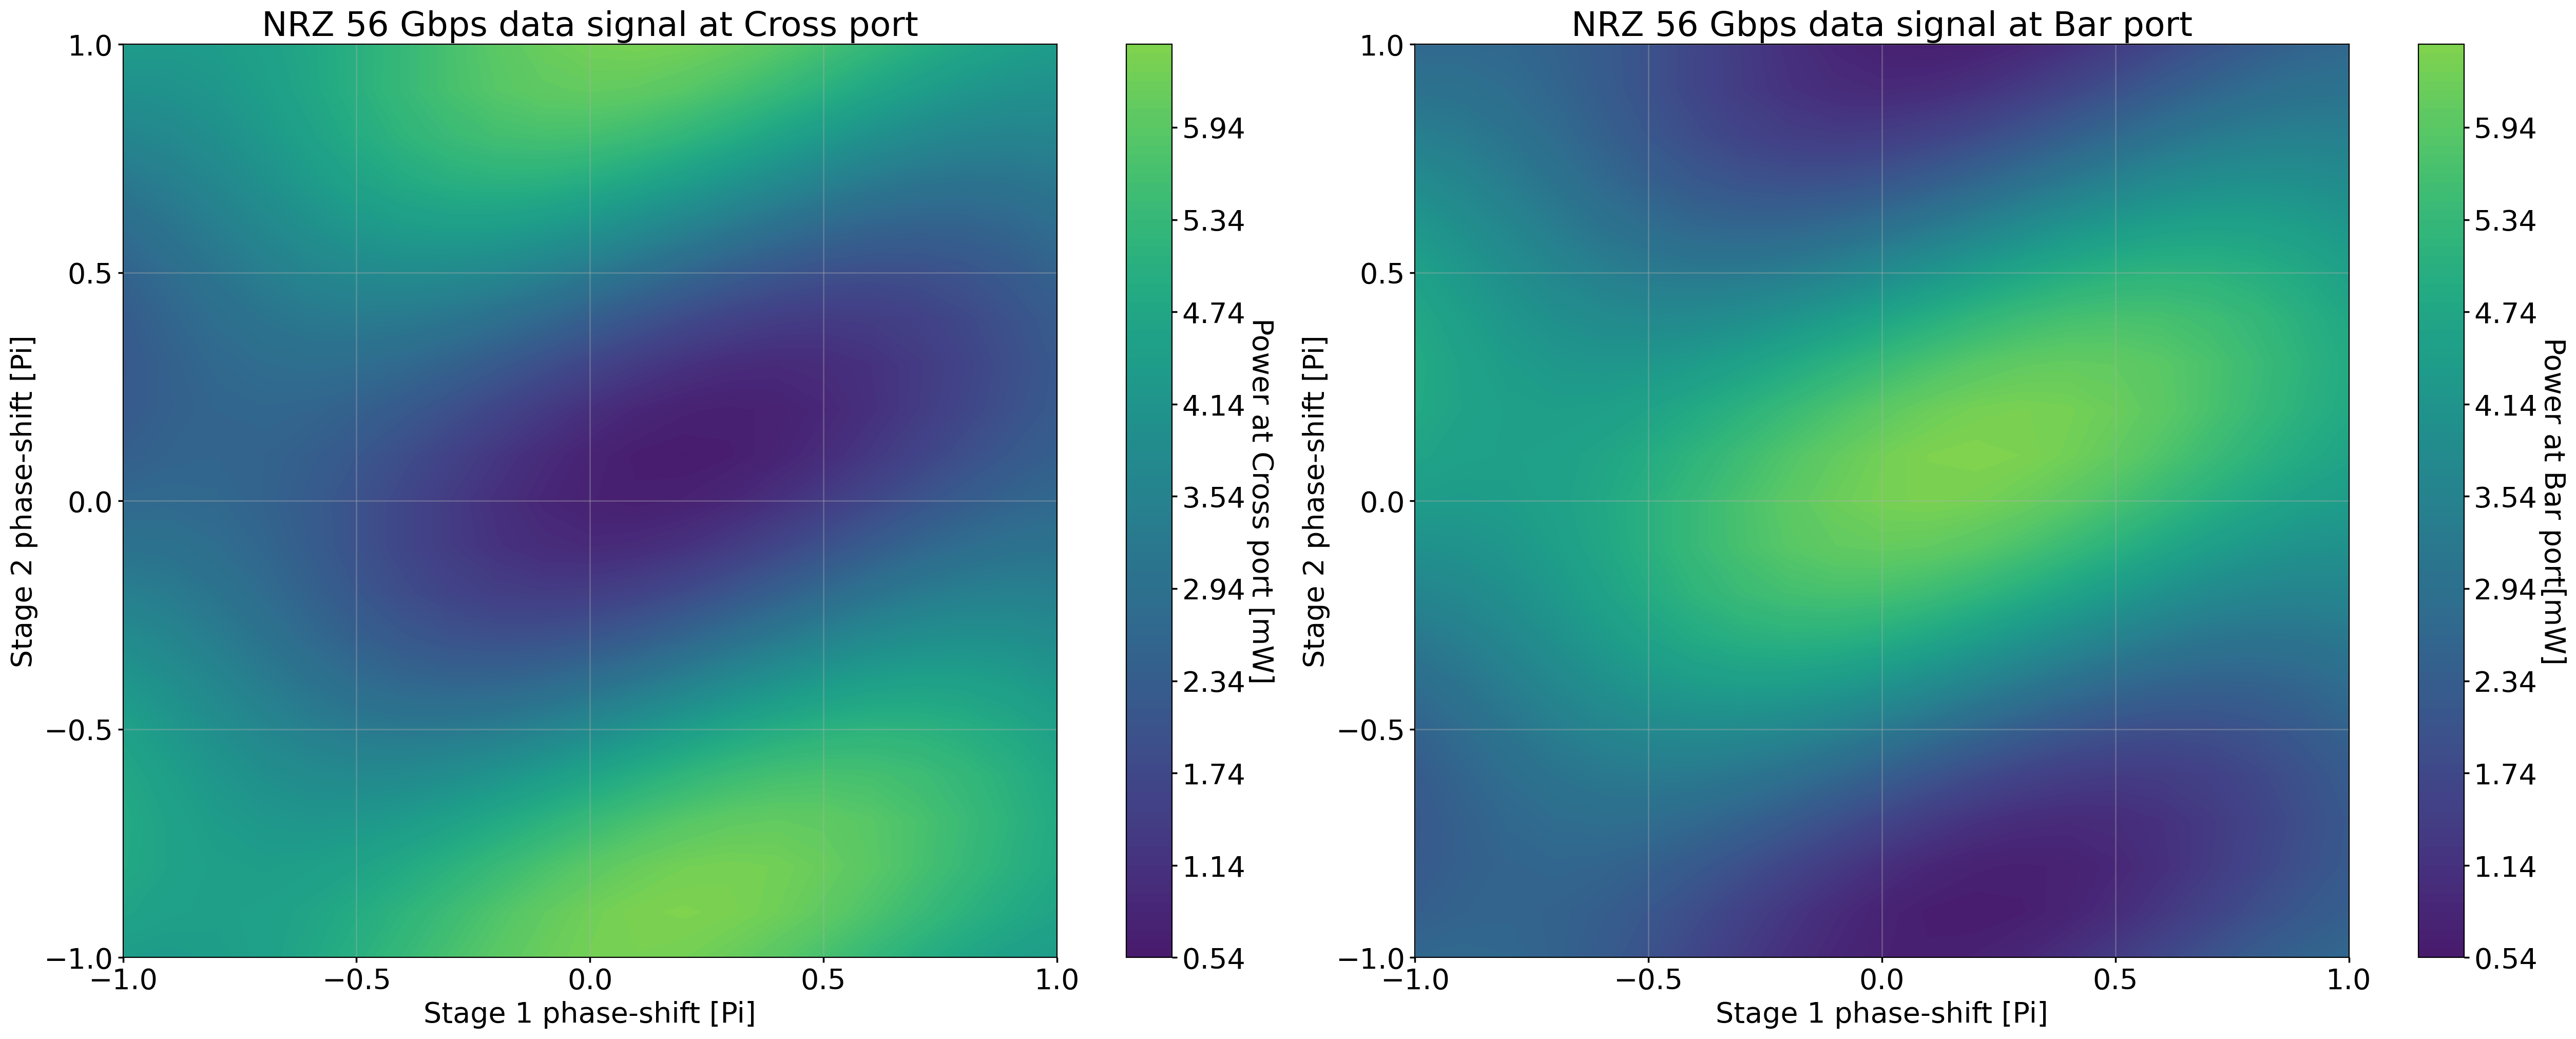

In [16]:
for idd_offset, wav_offset in enumerate(wav_offset_range):
  data_signal = np.zeros(len(optimization_wavelength_sweep))
  channel_wavelength_offset = channel_wavelength_array - wav_offset
  for idd_channel, channel_wavelength in enumerate(channel_wavelength_offset):
    freq_center = c/channel_wavelength
    frequency_sweep = c/optimization_wavelength_sweep
    diff_freq = freq_center - frequency_sweep
    Tb = 1/(56e9)
    tp = np.array(
        [0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])
    tp /= np.max(tp)
    data_signal += tp

  bar_port_power_nrz = np.zeros((num_samples,num_samples))
  cross_port_power_nrz = np.zeros((num_samples,num_samples))

  for idd_phi1, idd_ph2 in product(range(num_samples),range(num_samples)):
    bar_port_power_nrz[idd_phi1,idd_ph2] += np.sum(np.multiply(data_signal, bar_port_response_all[idd_phi1,idd_ph2,:]))/ np.sum(data_signal) * 8
    cross_port_power_nrz[idd_phi1,idd_ph2] += np.sum(np.multiply(data_signal, cross_port_response_all[idd_phi1,idd_ph2,:]))/ np.sum(data_signal) * 8

  if idd_offset == 0:
    for idd_phi1, idd_ph2 in product(range(num_samples),range(num_samples)):
      if cross_port_power_nrz[idd_phi1,idd_ph2] == np.max(cross_port_power_nrz):
        fix_idd_phi1 = idd_phi1
        fix_idd_phi2 = idd_ph2

  print(r"dfreq " + str(freq_offset_range[idd_offset]/1e9) + f" [GHz], Cross Port Power {cross_port_power_nrz[fix_idd_phi1, fix_idd_phi2]:0.2f} [mW], Bar Port Power {bar_port_power_nrz[fix_idd_phi1, fix_idd_phi2]:0.2f} [mW]")

  if idd_offset == 0:
    plt.figure(figsize=(25,10))
    plt.subplot(121)
    X, Y = np.meshgrid(phi1_range/np.pi, phi2_range/np.pi)
    plt.contourf(X, Y, cross_port_power_nrz, levels = 101)
    cbar = plt.colorbar()
    cbar.set_label("Power at Cross port [mW]", rotation=270, labelpad=20)
    plt.clim(0,8)
    plt.xticks(np.linspace(-1,1,5))
    plt.yticks(np.linspace(-1,1,5))
    plt.xlabel("Stage 1 phase-shift [Pi]")
    plt.ylabel("Stage 2 phase-shift [Pi]")
    plt.title("NRZ 56 Gbps data signal at Cross port")
    plt.subplot(122)
    X, Y = np.meshgrid(phi1_range/np.pi, phi2_range/np.pi)
    plt.contourf(X, Y, bar_port_power_nrz, levels = 101)
    cbar = plt.colorbar()
    cbar.set_label("Power at Bar port[mW]", rotation=270, labelpad=20)
    plt.clim(0,8)
    plt.xticks(np.linspace(-1,1,5))
    plt.yticks(np.linspace(-1,1,5))
    plt.xlabel("Stage 1 phase-shift [Pi]")
    plt.ylabel("Stage 2 phase-shift [Pi]")
    plt.title("NRZ 56 Gbps data signal at Bar port")

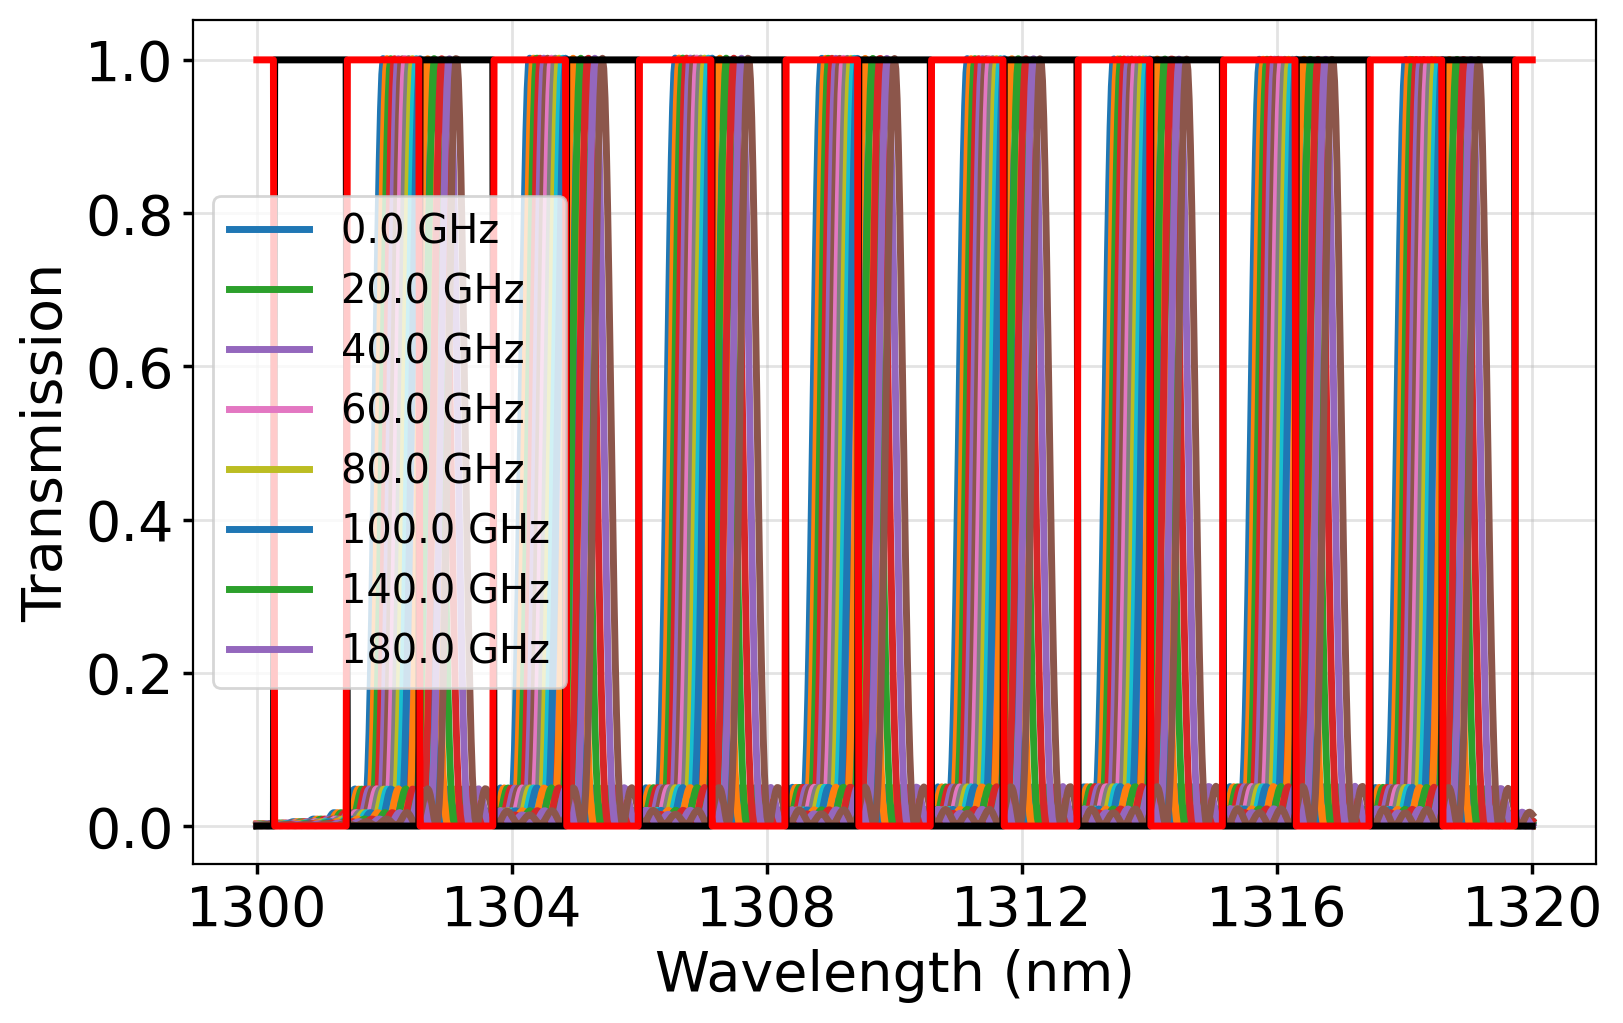

In [17]:
for idd_offset, wav_offset in enumerate(wav_offset_range):
  data_signal = np.zeros(len(optimization_wavelength_sweep))
  channel_wavelength_offset = channel_wavelength_array - wav_offset
  for idd_channel, channel_wavelength in enumerate(channel_wavelength_offset):
    freq_center = c/channel_wavelength
    frequency_sweep = c/optimization_wavelength_sweep
    diff_freq = freq_center - frequency_sweep
    Tb = 1/(56e9)
    tp = np.array(
        [0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])
    tp /= np.max(tp)
    data_signal += tp
  if idd_offset %2 == 0:
    plt.plot(optimization_wavelength_sweep*1e9, data_signal, label = str(freq_offset_range[idd_offset]/1e9) + " GHz")
  else:
    plt.plot(optimization_wavelength_sweep*1e9, data_signal)
plt.plot(optimization_wavelength_sweep*1e9, interleaver_400Ghz_FSR.calculate_optimal_transfer_function(), 'k', )
plt.plot(optimization_wavelength_sweep*1e9, 1-interleaver_400Ghz_FSR.calculate_optimal_transfer_function(), 'r')
plt.xticks(np.linspace(1300, 1320, 6))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend()
plt.show()